# Explore Sample Data set for Density Based Order Mining Tool
This purpose of this notebook is the initial exploration of some sample data sets for the Density Based Order Mining Tool. 
The purpose of the tool is to take in a large order file, and extract more useful information rather than generating summary statistics. In this section we will look at how to create the variables that will be fed to the clustering algorithm, the main focus will be on feature reduction and principal component analysis.  <br>

There are a lot of different ways to stratify SKU's for useful information, so we'll save each data set to be compared against from within the clustering algorithm. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
data_set = 'STEGS'
data_loc = 'Sample_data'

In [2]:
data = pd.read_csv('../Sample_data/'+data_set+ '/raw/ods2_ord_TempTable.txt', delimiter = '|')
#data = data.sample(100000)
print(data.shape)

(229516, 80)


In [3]:
data.columns = [x.replace( ' ', '') for x in data.columns]
for i, d in enumerate(data.dtypes):
    print(data.columns[i] + '-----' + str(d))

Link-----object
ShipDate-----object
CustomerOrderID-----int64
SubOrderID-----float64
SKU-----object
FacilityID-----object
CustomerORderType1-----float64
CustomerORderType2-----float64
ShipToID-----int64
ShipmentID-----object
ShipType1-----object
ShipType2-----object
CustomerID-----int64
CustomerDescription-----object
ShipToDescription-----object
ShipToAddress1-----float64
ShipToAddress2-----float64
ShipToCity-----object
ShipToState-----float64
ShipToPostalCode-----float64
ShipToCountry-----object
CustomerType1-----object
CustomerType2-----object
FacilityDescription-----object
FacilityAddress1-----float64
FacilityAddress2-----float64
FacilityCity-----object
FacilityState-----object
FacilityPostalCode-----int64
FacilityCountry-----object
FacilityType1-----float64
FacilityType2-----float64
SKUDescription-----object
SkuType1-----object
SKUType2-----object
SKUType3-----object
Lines-----int64
Cube-----float64
Weight-----float64
Units-----float64
UOH1s-----float64
EqUOH2s-----float64
EqUOH3s-

In [4]:
#data = data[(data.ShipType2 =='outbound') & (data.CustomerORderType2 == 'FINI')]
#Only include lines that have units I care about(uoh1-3)
data = data[data.UOH1s> 0] 
data['ShipDate'] = pd.to_datetime(data['ShipDate'])
data = data[data.LooseUOH1Lines + data.FullUOH2Lines + data.FullUOH3Lines > 0]
data.head()

,Link,ShipDate,CustomerOrderID,SubOrderID,SKU,FacilityID,CustomerORderType1,CustomerORderType2,ShipToID,ShipmentID,...,UOH4sOnUOH5s,EqUOH5sasUOH1s,EqUOH5sasUOH2s,EqUOH5sasUOH3s,EqUOH5sasUOH4s,LooseUOH1Lines,FullUOH2Lines,FullUOH3Lines,FullUOH4Lines,FullUOH5Lines
0,Link,2013-12-23,617776,NaN,APNT005005,OLD,NaN,NaN,263,SID0011507,...,0.0,0.000000e+00,0.000000e+00,2.000040e-10,0.0,0,0,1,0,0
1,Link,2013-12-23,617776,NaN,PBAR006398,MIL,NaN,NaN,263,SID0011507,...,0.0,0.000000e+00,5.000100e-11,0.000000e+00,0.0,0,1,0,0,0
2,Link,2013-12-23,617917,NaN,AGRA005364,OLD,NaN,NaN,361,SID0011611,...,0.0,1.000020e-11,6.250125e-11,0.000000e+00,0.0,1,1,0,0,0
3,Link,2014-08-10,650826,NaN,CSWE006473X,EUC,NaN,NaN,892,SID0037823,...,0.0,0.000000e+00,0.000000e+00,6.000120e-10,0.0,0,0,1,0,0
4,Link,2014-08-10,650826,NaN,CSWE006474X,EUC,NaN,NaN,892,SID0037823,...,0.0,0.000000e+00,0.000000e+00,3.000060e-10,0.0,0,0,1,0,0


# By SKU
Group by SKU, we'll add the features

-Number of Lines per Unit of Handling <br>
-Number of Unique  Shipdates <br>
-How long they are active(max date - min date)  <br>
-percent of days they are active(num days / active days) <br>
-Lines per Day <br>

We'll then perform some PCA and plot them 

In [5]:
numlines = data.groupby(by = 'SKU')['Lines'].sum()
totaldf = numlines
collist = ['Lines']
cols = ['LooseUOH1Lines', 'FullUOH2Lines', 'FullUOH3Lines']
col2 = ['LooseUOH1s', 'FullUOH2s', 'FullUOH3s']   
for i, col in enumerate(cols):
    newdf = data.groupby(by = 'SKU')[col].sum() / numlines #Percent share of lines
    totaldf = pd.concat([totaldf, newdf], axis = 1)
    collist.append(col)
    newdf_2 = data.groupby(by = 'SKU')[col2[i]].sum() / data.groupby(by = 'SKU')[col].sum() # Units per line
    totaldf = pd.concat([totaldf, newdf_2], axis = 1)
    colname = str(col2[i]) + 'per' + str(col)
    collist.append(colname)

In [6]:
cols = ['ShipDate']
for i in cols:
    newdf = data.groupby(by = 'SKU')[i].nunique()
    totaldf = pd.concat([totaldf, newdf], axis = 1)
    collist.append(i)

totaldf.columns = collist

mindate =  data.groupby(by = 'SKU')['ShipDate'].min()
mindate.rename('mindate', inplace = True)
maxdate =  data.groupby(by = 'SKU')['ShipDate'].max()
days_active = pd.concat([mindate, maxdate], axis = 1)
days_active['numdays'] = (pd.to_datetime(days_active['ShipDate']) - pd.to_datetime(days_active['mindate']))
days_active['numdays'] = days_active['numdays'].apply(lambda x: x.days + 1)

totaldf['numdays'] = days_active['numdays']
totaldf['perc_active'] = totaldf['ShipDate'] / totaldf['numdays']

In [7]:
totaldf.head()

,Lines,LooseUOH1Lines,LooseUOH1sperLooseUOH1Lines,FullUOH2Lines,FullUOH2sperFullUOH2Lines,FullUOH3Lines,FullUOH3sperFullUOH3Lines,ShipDate
SKU,,,,,,,,
AAMB004000,1,0.00000,NaN,1.000000,2.000000,0.000000,NaN,1
AAMB004002,13,0.00000,NaN,1.000000,2.846154,0.000000,NaN,13
AAMB004003,8,0.25000,4.500000,1.000000,2.750000,0.000000,NaN,8
AAMB004005,1,0.00000,NaN,0.000000,NaN,1.000000,1.00000,1
AAMB004012,288,0.03125,2.111111,0.982639,10.734982,0.111111,1.40625,151


totaldf['linesperday'] = totaldf['Lines'] / totaldf['numdays']


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#totaldf = totaldf[totaldf.Lines > np.percentile(totaldf.Lines, 10)]
totaldf.fillna(0, inplace = True)
col = totaldf.columns
x1 = totaldf
x = StandardScaler().fit_transform(totaldf)
covmat = pd.DataFrame(x, columns = col)

/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
covmat.describe()

,Lines,LooseUOH1Lines,LooseUOH1sperLooseUOH1Lines,FullUOH2Lines,FullUOH2sperFullUOH2Lines,FullUOH3Lines,FullUOH3sperFullUOH3Lines,ShipDate
count,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03
mean,-1.676201e-16,-2.220044e-16,-1.587758e-16,-7.552213e-16,-7.420806e-16,2.864806e-16,3.708390e-16,-5.151459e-16
std,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00
min,-3.658235e-01,-1.327262e+00,-1.806586e+00,-1.597218e+00,-1.472610e+00,-1.794966e+00,-9.198585e-01,-5.274659e-01
25%,-3.568516e-01,-8.173575e-01,-5.032440e-01,-7.744918e-01,-5.409326e-01,-6.695907e-01,-5.850882e-01,-5.061953e-01
50%,-2.940479e-01,-1.733190e-01,1.100934e-01,-8.265356e-02,-1.682616e-01,2.537050e-01,-2.503179e-01,-3.998424e-01
75%,-6.077733e-02,6.814539e-01,5.828744e-01,8.811604e-01,4.321528e-01,8.949558e-01,1.702909e-01,4.298841e-03
max,2.768945e+01,1.685812e+00,7.968480e+00,1.431911e+00,4.862797e+00,1.107318e+00,1.046233e+01,1.012910e+01


In [10]:
outliers = totaldf.index.values[np.where(x > 20)[0]].tolist()

In [11]:
outliers

['PDAN006700']

In [12]:
totaldf.loc[outliers]

,Lines,LooseUOH1Lines,LooseUOH1sperLooseUOH1Lines,FullUOH2Lines,FullUOH2sperFullUOH2Lines,FullUOH3Lines,FullUOH3sperFullUOH3Lines,ShipDate
SKU,,,,,,,,
PDAN006700,3128,0.038683,2.31405,0.157289,5.270325,0.851023,1.265965,414


In [13]:
x[np.where(x > 20)[0]]

array([[27.68945286, -1.21070801, -0.29858698, -1.12076957,  0.49148732,
         0.67494451, -0.4960509 ,  8.25728788]])

In [14]:
covmat.cov()

,Lines,LooseUOH1Lines,LooseUOH1sperLooseUOH1Lines,FullUOH2Lines,FullUOH2sperFullUOH2Lines,FullUOH3Lines,FullUOH3sperFullUOH3Lines,ShipDate
Lines,1.000181,-0.238698,0.018948,-0.190012,0.087492,0.117989,-0.018817,0.869739
LooseUOH1Lines,-0.238698,1.000181,0.404677,0.334041,-0.123574,-0.396009,-0.129280,-0.287824
LooseUOH1sperLooseUOH1Lines,0.018948,0.404677,1.000181,0.164691,0.125967,-0.102193,-0.020471,0.049294
FullUOH2Lines,-0.190012,0.334041,0.164691,1.000181,0.339536,-0.315906,-0.069198,-0.242856
FullUOH2sperFullUOH2Lines,0.087492,-0.123574,0.125967,0.339536,1.000181,0.029529,0.012573,0.076778
FullUOH3Lines,0.117989,-0.396009,-0.102193,-0.315906,0.029529,1.000181,0.482032,0.148666
FullUOH3sperFullUOH3Lines,-0.018817,-0.129280,-0.020471,-0.069198,0.012573,0.482032,1.000181,-0.011055
ShipDate,0.869739,-0.287824,0.049294,-0.242856,0.076778,0.148666,-0.011055,1.000181


In [15]:
def find_components(data, ratio = .85):
    pca = PCA(n_components=None).fit(data)
    components = pca.components_
    ex_var = pca.explained_variance_ratio_
    # select components
    sums = ex_var.cumsum()
    plt.figure(figsize = (6, 4))
    plt.plot(sums.tolist())
    plt.axhline(ratio, color = 'r', linestyle = 'dashed')
    plt.ylim(0,1)
    plt.xlim(0,8)
    n_comps = 0
    for i, s in enumerate(sums):
        print('{} : {:.2f}'.format(i+1, s))
        if s > ratio:
            n_comps = i
            plt.axvline(i, linestyle = 'dashed', color = 'black' )
            plt.show()
            break
    return n_comps + 1

1 : 0.30
2 : 0.50
3 : 0.66
4 : 0.80
5 : 0.89


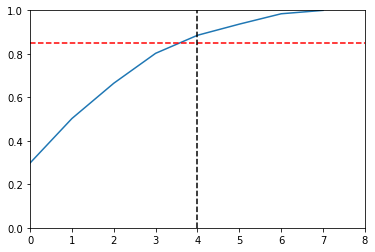

5

In [16]:
find_components(x)

In [17]:
pca = PCA(n_components = 4)
pca.fit(x)
X=pca.transform(x)

In [18]:
pc = pd.DataFrame(X)

In [19]:
pc.set_index(totaldf.index.values, inplace = True)

In [20]:
pc.columns = ['pc' + str(i) for i in np.arange(0, 4)]

In [21]:
pc.sort_values(by = 'pc1', ascending = False).head()

,pc0,pc1,pc2,pc3
PDAN006700,17.837310,16.792782,-1.522659,1.779579
AMXO006834,13.350986,11.722266,-0.572366,1.268433
PDAN006386,13.030722,11.447977,-0.822632,1.098095
PDAN006370,12.937724,11.442628,-0.817591,1.117274
AOGA005350,11.672265,10.515401,-1.240795,1.316022


In [22]:
def plot_4D(X, n):
    from mpl_toolkits.mplot3d import Axes3D
    figDBSCAN3D = plt.figure(figsize=(12, 12))
    ax = figDBSCAN3D.add_subplot(111, projection='3d')
    if n == 4:
        ax.scatter(X[:, 0], X[:, 1],X[:, 2], c= X[:, 3], cmap = 'jet')
    else:
        ax.scatter(X[:, 0], X[:, 1],X[:, 2], alpha = 0.25)
    return ax

# Base transformation

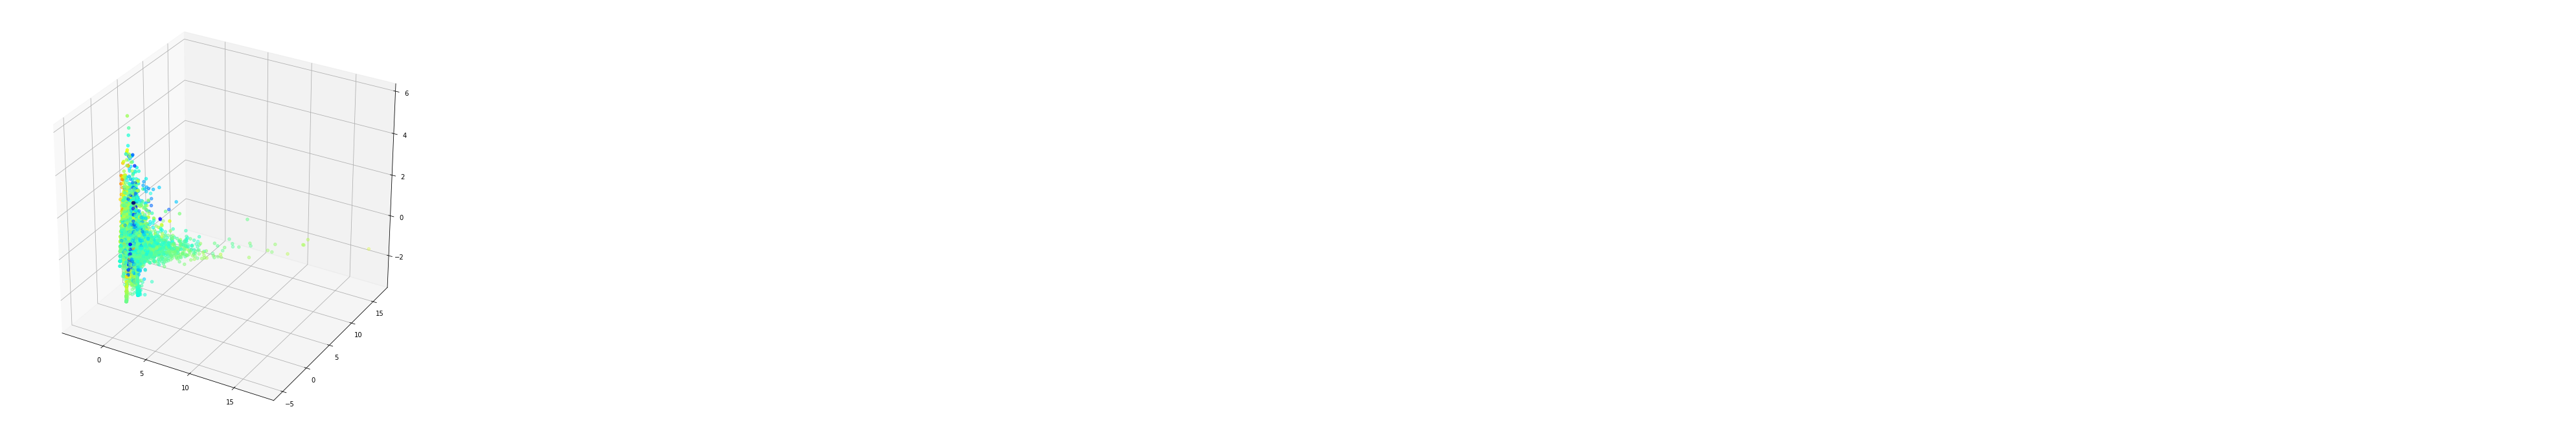

In [23]:
plot_4D(X, 4)

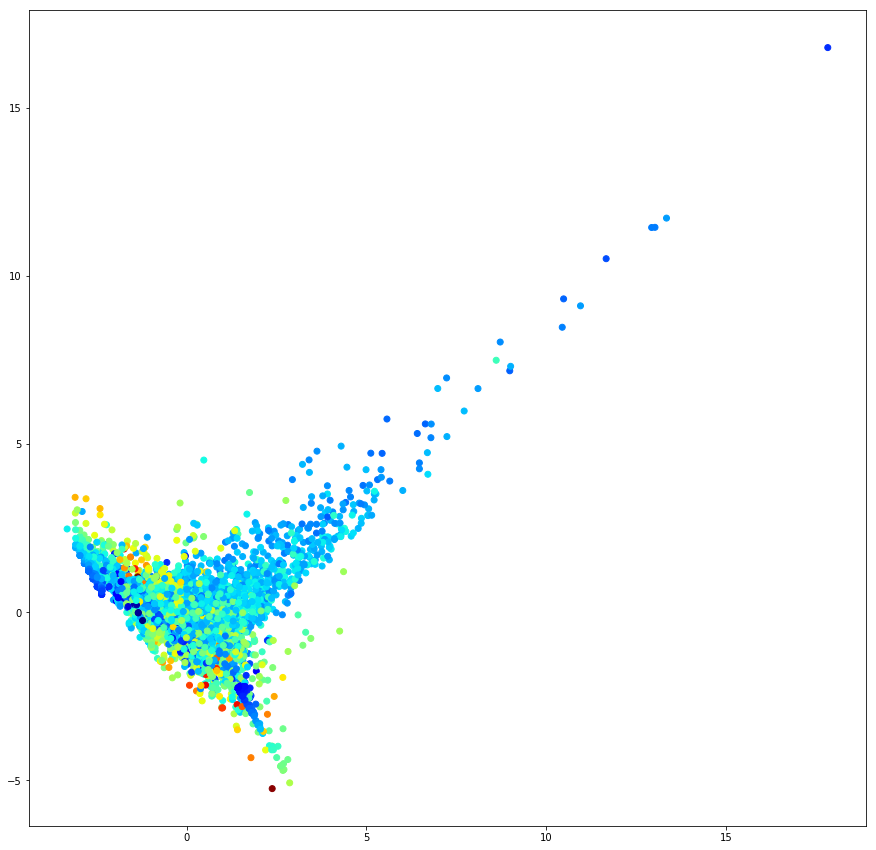

In [24]:
def plot_3D(X):
    plt.figure(figsize = (15, 15))
    plt.scatter(X[:, 0], X[:, 1], c = X[:, 2], cmap = 'jet')
    return 

plot_3D(X)

In [25]:
pickle_loc = '../' + data_loc +'/' +  data_set + '/pickle/'
#Export for clustering
SKU = pd.Series(totaldf.index.values)
def pickle_out_SKU(X, pca_, name):
    df = pd.DataFrame(X, columns = ['PCA' + str(i) for i in np.arange(X.shape[1])])
    df.set_index(SKU, 'SKU', inplace = True)
    output = open(pickle_loc +  '/sku_X' + name + '.pkl', 'wb')
    pickle.dump(df, output)
    output = open(pickle_loc + '/sku_variance' + name + '.pkl', 'wb')
    pickle.dump(pca.explained_variance_, output)
       
    
pickle_out_SKU(X, pca, 'base')


# Use SkuType1 , one hot encoded

1 : 0.19
2 : 0.34
3 : 0.47
4 : 0.57
5 : 0.66
6 : 0.74
7 : 0.82
8 : 0.88


/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


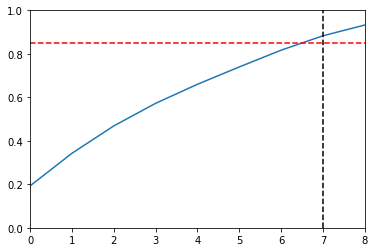

In [26]:
# Add Clusters
labeldf = data.groupby(by = ['SKU', 'SkuType1']).count().reset_index()




onehot = pd.get_dummies(labeldf['SkuType1']).set_index(labeldf['SKU'])
clustdf = totaldf.join(onehot)
clustdf.head()
x = StandardScaler().fit_transform(clustdf)
numcomps = find_components(x)

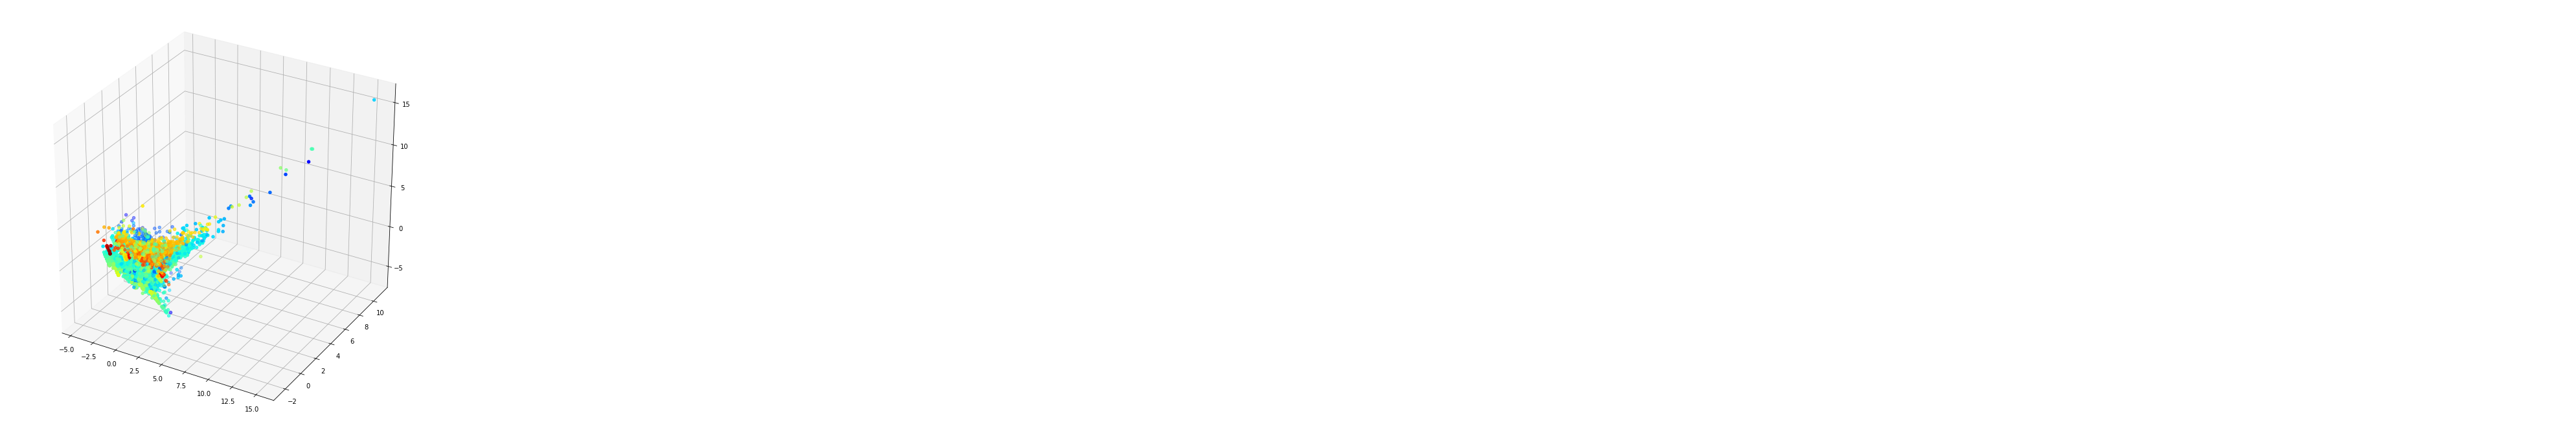

In [27]:
pca = PCA(n_components = numcomps)
pca.fit(x)
X=pca.transform(x)
plot_4D(X, 4)

In [28]:
pickle_out_SKU(X, pca, 'typesep')

# Log Volume 
it looks like the volume is really making it tough to do do efficient PCA, it would probably make sense to log fit in this case. We'll also keep our categorical variables binary.  

In [29]:
# Lets' try a pipeline, log fit the volume, in-max the categories to maintain binary,  and standardize all others 
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
cols = [col for col in data['SkuType1'].unique()]
cols2 = [x for x in cols if x != 'Lines']
cols.append('Lines')
numcols = [col for col in clustdf.columns.tolist() if col not in cols]
def get_cat_cols(df):
    return df[cols2]

def get_vol_cols(df):
    return np.log(df['Lines']).values.reshape(clustdf.shape[0], 1) * 2

def get_num_cols(df):
    return df[numcols]


vec = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), StandardScaler()),
    make_pipeline(FunctionTransformer(get_cat_cols, validate=False), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_vol_cols, validate = False))
])



1 : 0.65
2 : 0.75
3 : 0.82
4 : 0.88


/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


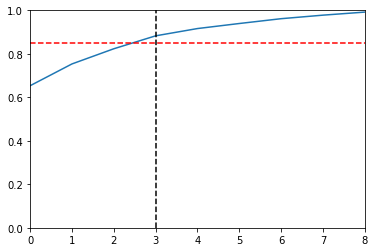

In [30]:
x = vec.fit_transform(clustdf)
numcomps = find_components(x)

In [31]:
x.shape

(5517, 13)

In [32]:
np.cov(x).shape

(5517, 5517)

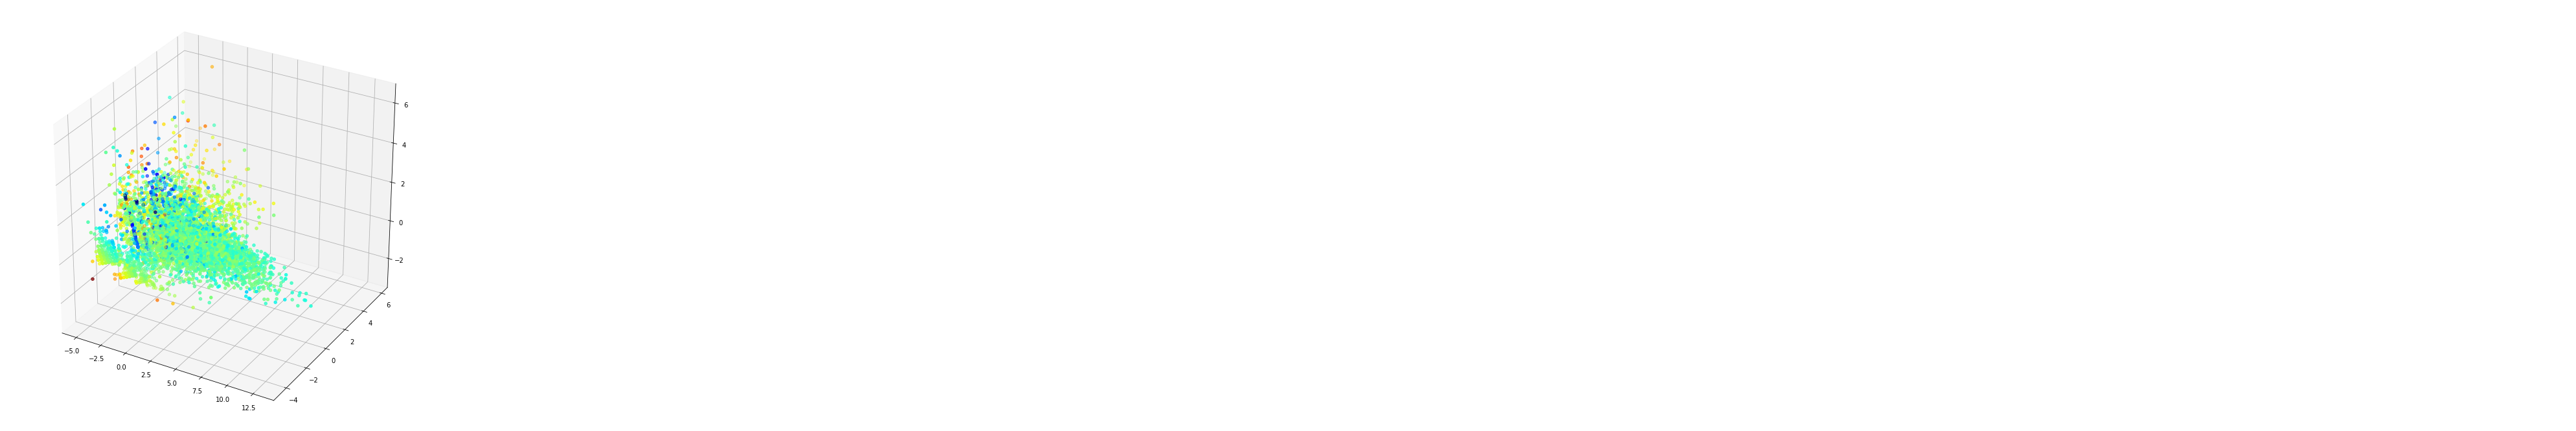

In [33]:
pca = PCA(n_components = numcomps)
X = pca.fit_transform(x)
plot_4D(X, 4)

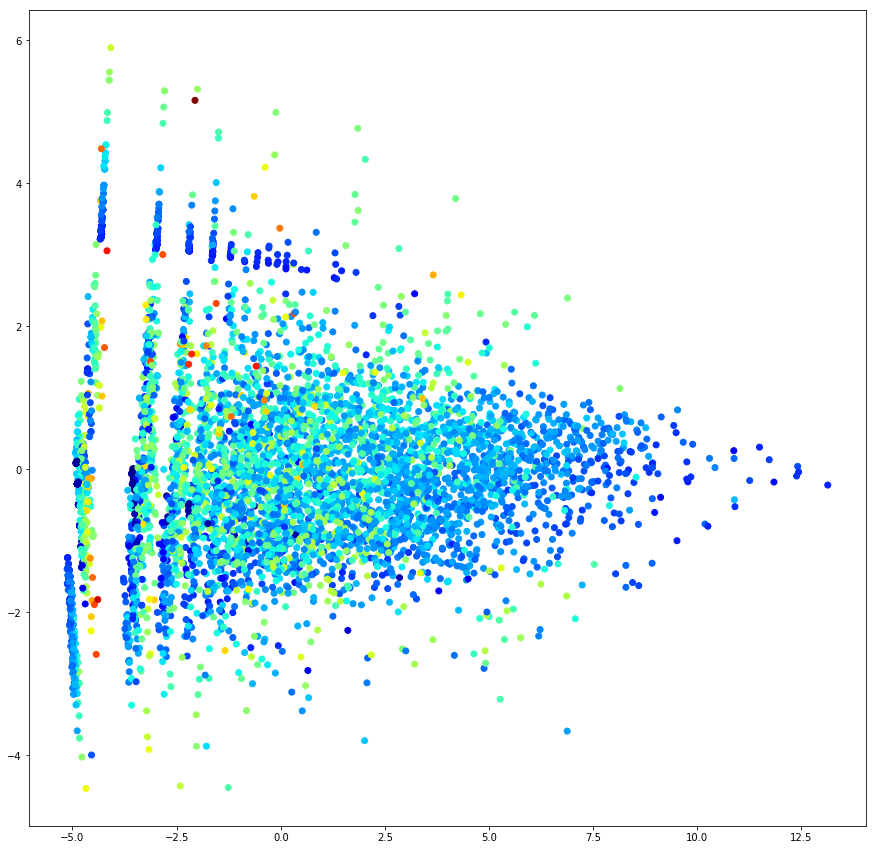

In [34]:
plot_3D(X)

In [35]:
pickle_out_SKU(X, pca, 'logvolume')

<BarContainer object of 4 artists>

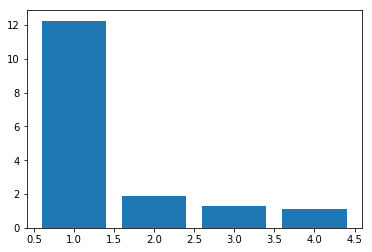

In [36]:
plt.bar(height = pca.explained_variance_ , x = np.arange(1,5))

In [37]:
df = pd.DataFrame(X, columns = ['PCA' + str(i) for i in np.arange(1,5)])
df.describe()

,PCA1,PCA2,PCA3,PCA4
count,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03
mean,2.529143e-16,-1.574476e-16,-5.230243e-16,-2.927189e-16
std,3.500209e+00,1.371059e+00,1.144107e+00,1.056362e+00
min,-5.127825e+00,-4.465329e+00,-2.887447e+00,-4.748717e+00
25%,-2.933864e+00,-8.398865e-01,-6.807283e-01,-5.342113e-01
50%,-3.624619e-01,-9.344694e-02,-1.678065e-01,1.075287e-01
75%,2.508714e+00,6.224198e-01,6.204254e-01,6.125775e-01
max,1.313109e+01,5.898431e+00,6.284070e+00,5.360791e+00


In [38]:
df.head()

,PCA1,PCA2,PCA3,PCA4
0,-4.737445,0.273798,-1.169895,-2.391021
1,0.245094,-0.361248,-1.129742,-2.445096
2,-0.687936,-1.885426,-0.640244,-0.458856
3,-4.302564,3.293078,-1.505992,-0.625937
4,7.069577,-2.091030,0.665273,-2.681759


In [39]:
pca.explained_variance_

array([12.2514619 ,  1.87980306,  1.30898188,  1.1159002 ])

# Seasonality
Let's one hot encode percenet of lines by month of year, and see if that generates intergesting results

In [40]:
import math
data['month'] = data['ShipDate'].apply(lambda x: math.ceil(x.month / 3))

In [41]:
by_month = data.pivot_table(index = 'SKU', columns = 'month', values = 'Lines', aggfunc = np.sum)

In [42]:
by_month = by_month.divide(numlines, axis = 0)
by_month.fillna(0, inplace = True)

In [43]:
by_month.head()

month,1,2,3,4
SKU,,,,
AAMB004000,1.000000,0.000000,0.000000,0.000000
AAMB004002,0.076923,0.076923,0.230769,0.615385
AAMB004003,0.250000,0.500000,0.250000,0.000000
AAMB004005,1.000000,0.000000,0.000000,0.000000
AAMB004012,0.496528,0.152778,0.086806,0.263889


In [44]:
clustdf.head()

,Lines,LooseUOH1Lines,LooseUOH1sperLooseUOH1Lines,FullUOH2Lines,FullUOH2sperFullUOH2Lines,FullUOH3Lines,FullUOH3sperFullUOH3Lines,ShipDate,A,C,M,P,R
SKU,,,,,,,,,,,,,
AAMB004000,1,0.00000,0.000000,1.000000,2.000000,0.000000,0.00000,1,1,0,0,0,0
AAMB004002,13,0.00000,0.000000,1.000000,2.846154,0.000000,0.00000,13,1,0,0,0,0
AAMB004003,8,0.25000,4.500000,1.000000,2.750000,0.000000,0.00000,8,1,0,0,0,0
AAMB004005,1,0.00000,0.000000,0.000000,0.000000,1.000000,1.00000,1,1,0,0,0,0
AAMB004012,288,0.03125,2.111111,0.982639,10.734982,0.111111,1.40625,151,1,0,0,0,0


In [45]:
df = clustdf.join(by_month)
#df.drop(['A', 'C', 'M', 'P', 'R'], inplace = True, axis = 1)

In [46]:
df.head()

,Lines,LooseUOH1Lines,LooseUOH1sperLooseUOH1Lines,FullUOH2Lines,FullUOH2sperFullUOH2Lines,FullUOH3Lines,FullUOH3sperFullUOH3Lines,ShipDate,A,C,M,P,R,1,2,3,4
SKU,,,,,,,,,,,,,,,,,
AAMB004000,1,0.00000,0.000000,1.000000,2.000000,0.000000,0.00000,1,1,0,0,0,0,1.000000,0.000000,0.000000,0.000000
AAMB004002,13,0.00000,0.000000,1.000000,2.846154,0.000000,0.00000,13,1,0,0,0,0,0.076923,0.076923,0.230769,0.615385
AAMB004003,8,0.25000,4.500000,1.000000,2.750000,0.000000,0.00000,8,1,0,0,0,0,0.250000,0.500000,0.250000,0.000000
AAMB004005,1,0.00000,0.000000,0.000000,0.000000,1.000000,1.00000,1,1,0,0,0,0,1.000000,0.000000,0.000000,0.000000
AAMB004012,288,0.03125,2.111111,0.982639,10.734982,0.111111,1.40625,151,1,0,0,0,0,0.496528,0.152778,0.086806,0.263889


In [47]:
df.shape

(5517, 17)

/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


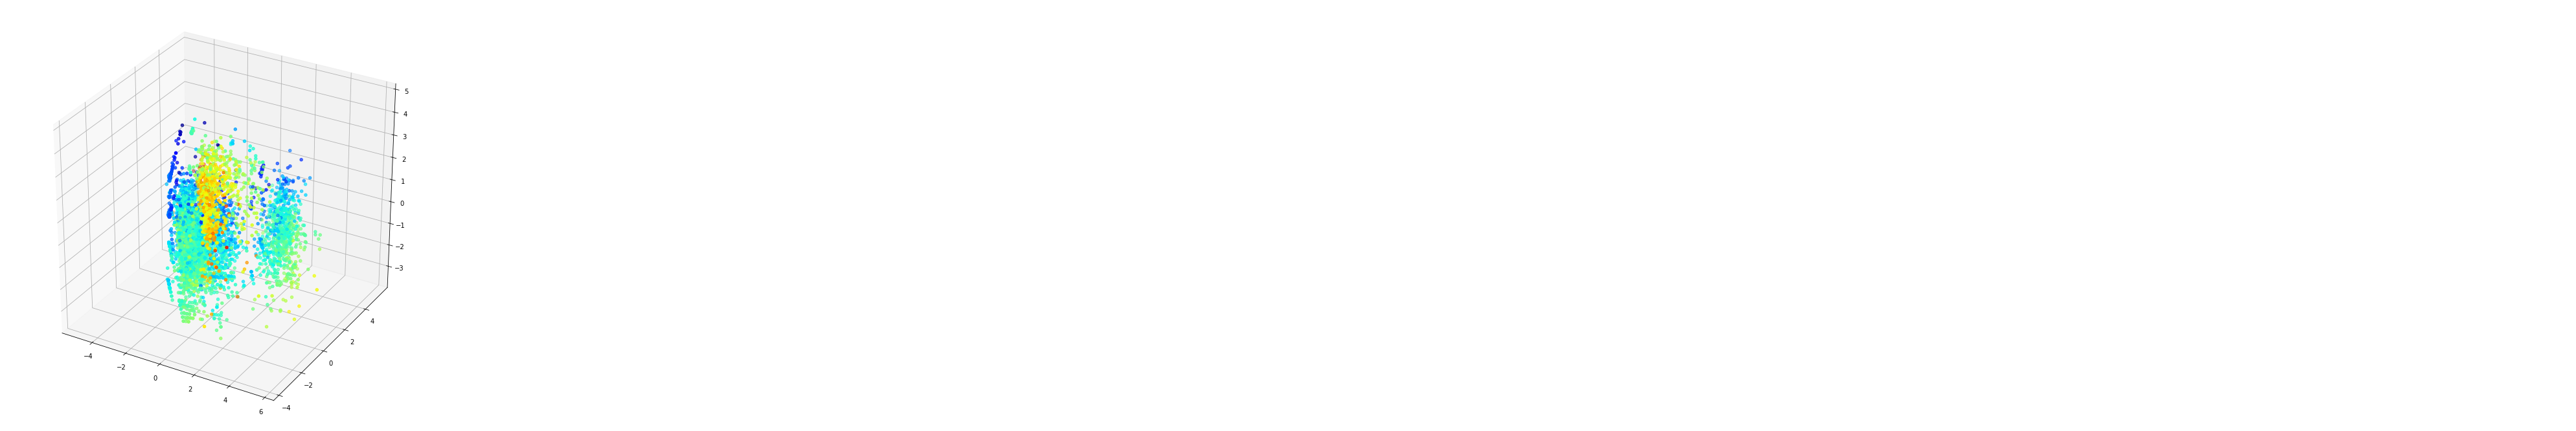

In [48]:
# Lets' try log fitting the volume and standard scaling from there
df['Lines'] = np.log(df['Lines'])
x = StandardScaler().fit_transform(df)
pca = PCA(n_components =10)
X = pca.fit_transform(x)
plot_4D(X, 4)

In [49]:
X

array([[-0.4176616 , -1.99724428, -1.04366564, ..., -2.04835658,
         0.10487593,  1.59001956],
       [-0.27646806, -1.11709524, -0.01810539, ..., -1.7167921 ,
         0.203529  ,  1.0945752 ],
       [ 0.64735067, -0.98644699, -2.11343261, ..., -0.40762667,
         0.10638686, -0.32619423],
       ...,
       [ 1.4048452 ,  2.05805615, -1.8084542 , ...,  4.27338848,
        -5.71183619,  0.51368788],
       [ 2.59336243,  1.03665706, -1.89157209, ...,  2.8417714 ,
        -5.21620622,  1.81922141],
       [ 3.23599062,  0.59915439, -2.74130174, ...,  3.7728226 ,
        -5.57717278,  1.23456655]])

In [50]:
df.head()

,Lines,LooseUOH1Lines,LooseUOH1sperLooseUOH1Lines,FullUOH2Lines,FullUOH2sperFullUOH2Lines,FullUOH3Lines,FullUOH3sperFullUOH3Lines,ShipDate,A,C,M,P,R,1,2,3,4
SKU,,,,,,,,,,,,,,,,,
AAMB004000,0.000000,0.00000,0.000000,1.000000,2.000000,0.000000,0.00000,1,1,0,0,0,0,1.000000,0.000000,0.000000,0.000000
AAMB004002,2.564949,0.00000,0.000000,1.000000,2.846154,0.000000,0.00000,13,1,0,0,0,0,0.076923,0.076923,0.230769,0.615385
AAMB004003,2.079442,0.25000,4.500000,1.000000,2.750000,0.000000,0.00000,8,1,0,0,0,0,0.250000,0.500000,0.250000,0.000000
AAMB004005,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.00000,1,1,0,0,0,0,1.000000,0.000000,0.000000,0.000000
AAMB004012,5.662960,0.03125,2.111111,0.982639,10.734982,0.111111,1.40625,151,1,0,0,0,0,0.496528,0.152778,0.086806,0.263889


1 : 0.17
2 : 0.30
3 : 0.40
4 : 0.50
5 : 0.57
6 : 0.64
7 : 0.71
8 : 0.77
9 : 0.83
10 : 0.88


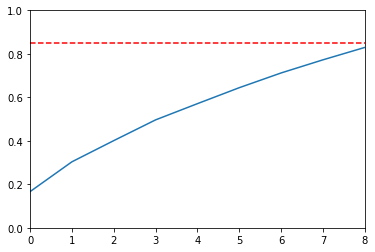

10

In [51]:
find_components(x)

In [52]:
x[0, :]

array([-1.37263182, -1.32726235, -1.80658609,  1.43191122, -0.72726816,
       -1.7949663 , -0.91985853, -0.52746592,  0.67418209, -0.41752785,
       -0.06327432, -0.41573024, -0.11336274,  2.31954247, -0.59435964,
       -0.68960407, -0.89123755])

In [53]:
x = StandardScaler().fit_transform(df)
covmat = pd.DataFrame(x, columns = df.columns)

/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/colin/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [54]:
covmat.describe()

,Lines,LooseUOH1Lines,LooseUOH1sperLooseUOH1Lines,FullUOH2Lines,FullUOH2sperFullUOH2Lines,FullUOH3Lines,FullUOH3sperFullUOH3Lines,ShipDate,A,C,M,P,R,1,2,3,4
count,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03,5.517000e+03
mean,3.633530e-16,-2.220044e-16,-1.587758e-16,-7.552213e-16,-7.420806e-16,2.864806e-16,3.708390e-16,-5.151459e-16,-1.424273e-14,-1.501196e-14,-2.158792e-15,1.568101e-14,1.126282e-15,-4.796679e-15,-6.495922e-16,2.310721e-15,-3.013279e-15
std,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00,1.000091e+00
min,-1.372632e+00,-1.327262e+00,-1.806586e+00,-1.597218e+00,-1.472610e+00,-1.794966e+00,-9.198585e-01,-5.274659e-01,-1.483279e+00,-4.175278e-01,-6.327432e-02,-4.157302e-01,-1.133627e-01,-7.803000e-01,-5.943596e-01,-6.896041e-01,-8.912375e-01
25%,-9.596175e-01,-8.173575e-01,-5.032440e-01,-7.744918e-01,-5.409326e-01,-6.695907e-01,-5.850882e-01,-5.061953e-01,-1.483279e+00,-4.175278e-01,-6.327432e-02,-4.157302e-01,-1.133627e-01,-7.803000e-01,-5.943596e-01,-6.896041e-01,-8.912375e-01
50%,-6.340751e-02,-1.733190e-01,1.100934e-01,-8.265356e-02,-1.682616e-01,2.537050e-01,-2.503179e-01,-3.998424e-01,6.741821e-01,-4.175278e-01,-6.327432e-02,-4.157302e-01,-1.133627e-01,-5.924307e-01,-5.943596e-01,-6.064622e-01,-3.463877e-01
75%,7.458353e-01,6.814539e-01,5.828744e-01,8.811604e-01,4.321528e-01,8.949558e-01,1.702909e-01,4.298841e-03,6.741821e-01,-4.175278e-01,-6.327432e-02,-4.157302e-01,-1.133627e-01,5.974078e-01,2.808049e-01,3.392765e-01,6.654762e-01
max,3.422887e+00,1.685812e+00,7.968480e+00,1.431911e+00,4.862797e+00,1.107318e+00,1.046233e+01,1.012910e+01,6.741821e-01,2.395050e+00,1.580420e+01,2.405406e+00,8.821241e+00,2.319542e+00,2.906298e+00,2.054077e+00,1.833012e+00


In [55]:
pickle_out_SKU(X, pca, 'seasonal')

In [57]:
#save the SKU features so we can look at those details as well when comparing
output = open("../" + data_loc + '/'+ data_set  + '/pickle/sku_Y.pkl', 'wb')
pickle.dump(df, output)



In [58]:
df.head()

,Lines,LooseUOH1Lines,LooseUOH1sperLooseUOH1Lines,FullUOH2Lines,FullUOH2sperFullUOH2Lines,FullUOH3Lines,FullUOH3sperFullUOH3Lines,ShipDate,A,C,M,P,R,1,2,3,4
SKU,,,,,,,,,,,,,,,,,
AAMB004000,0.000000,0.00000,0.000000,1.000000,2.000000,0.000000,0.00000,1,1,0,0,0,0,1.000000,0.000000,0.000000,0.000000
AAMB004002,2.564949,0.00000,0.000000,1.000000,2.846154,0.000000,0.00000,13,1,0,0,0,0,0.076923,0.076923,0.230769,0.615385
AAMB004003,2.079442,0.25000,4.500000,1.000000,2.750000,0.000000,0.00000,8,1,0,0,0,0,0.250000,0.500000,0.250000,0.000000
AAMB004005,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.00000,1,1,0,0,0,0,1.000000,0.000000,0.000000,0.000000
AAMB004012,5.662960,0.03125,2.111111,0.982639,10.734982,0.111111,1.40625,151,1,0,0,0,0,0.496528,0.152778,0.086806,0.263889


In [59]:
data.head()

,Link,ShipDate,CustomerOrderID,SubOrderID,SKU,FacilityID,CustomerORderType1,CustomerORderType2,ShipToID,ShipmentID,...,EqUOH5sasUOH1s,EqUOH5sasUOH2s,EqUOH5sasUOH3s,EqUOH5sasUOH4s,LooseUOH1Lines,FullUOH2Lines,FullUOH3Lines,FullUOH4Lines,FullUOH5Lines,month
0,Link,2013-12-23,617776,NaN,APNT005005,OLD,NaN,NaN,263,SID0011507,...,0.000000e+00,0.000000e+00,2.000040e-10,0.0,0,0,1,0,0,4
1,Link,2013-12-23,617776,NaN,PBAR006398,MIL,NaN,NaN,263,SID0011507,...,0.000000e+00,5.000100e-11,0.000000e+00,0.0,0,1,0,0,0,4
2,Link,2013-12-23,617917,NaN,AGRA005364,OLD,NaN,NaN,361,SID0011611,...,1.000020e-11,6.250125e-11,0.000000e+00,0.0,1,1,0,0,0,4
3,Link,2014-08-10,650826,NaN,CSWE006473X,EUC,NaN,NaN,892,SID0037823,...,0.000000e+00,0.000000e+00,6.000120e-10,0.0,0,0,1,0,0,3
4,Link,2014-08-10,650826,NaN,CSWE006474X,EUC,NaN,NaN,892,SID0037823,...,0.000000e+00,0.000000e+00,3.000060e-10,0.0,0,0,1,0,0,3


In [60]:
data.columns

Index(['Link', 'ShipDate', 'CustomerOrderID', 'SubOrderID', 'SKU',
       'FacilityID', 'CustomerORderType1', 'CustomerORderType2', 'ShipToID',
       'ShipmentID', 'ShipType1', 'ShipType2', 'CustomerID',
       'CustomerDescription', 'ShipToDescription', 'ShipToAddress1',
       'ShipToAddress2', 'ShipToCity', 'ShipToState', 'ShipToPostalCode',
       'ShipToCountry', 'CustomerType1', 'CustomerType2',
       'FacilityDescription', 'FacilityAddress1', 'FacilityAddress2',
       'FacilityCity', 'FacilityState', 'FacilityPostalCode',
       'FacilityCountry', 'FacilityType1', 'FacilityType2', 'SKUDescription',
       'SkuType1', 'SKUType2', 'SKUType3', 'Lines', 'Cube', 'Weight', 'Units',
       'UOH1s', 'EqUOH2s', 'EqUOH3s', 'EqUOH4s', 'EqUOH5s', 'LooseUOH1s',
       'FullUOH2s', 'FullUOH3s', 'FullUOH4s', 'FullUOH5s', 'UnitsOnUOH1s',
       'UnitsOnUOH2s', 'UnitsOnUOH3s', 'UnitsOnUOH4s', 'UnitsOnUOH5s',
       'UOH1sOnUOH2s', 'UOH1sOnUOH3s', 'UOH1sOnUOH4s', 'UOH1sOnUOH5s',
       'EqUOH2

In [64]:
collist = ['SKU'] + data['SkuType1'].unique().tolist()
ocadf = pd.DataFrame(columns = collist)
for i in data['SKU'].unique():
    orders = data[data.SKU == i]['CustomerOrderID'].unique()
    oca = data[data.CustomerOrderID.isin(orders)].pivot_table(index = 'CustomerOrderID', columns = 'SkuType1', values = 'Lines', aggfunc = np.sum)
    oca = oca.sum(axis = 0) 
    oca = oca / oca.sum()
    oca['SKU'] = i
    ocadf = ocadf.append(oca, ignore_index = True)
    

In [65]:
ocadf.set_index('SKU', inplace = True)
ocadf.fillna(0, inplace = True)

In [66]:
ocadf.head()

,A,P,C,R,M
SKU,,,,,
APNT005005,0.838672,0.156086,0.001165,0.001165,0.002912
PBAR006398,0.631835,0.367669,0.000099,0.000000,0.000397
AGRA005364,0.973684,0.026316,0.000000,0.000000,0.000000
CSWE006473X,0.000000,0.000000,0.976744,0.023256,0.000000
CSWE006474X,0.000000,0.000000,0.991228,0.008772,0.000000
